# Digit Coloring Notebook

Colored MNIST with colored digits according to the palette and controlled spurious correlation between digit label and digit color. The notebook follows similar design: 95/5 biased train vs inverted test mapping, reproducible seeds, saved artifacts, and sanity checks. Workflow: (1) configure paths/seeds, (2) helper functions for color sampling and compositing, (3) dataset generation to disk (images + labels.csv), (4) sanity checks (sample grid, color histograms, digit color consistency, bias ratio).

In [1]:
import math
import random
import shutil # for file copying and removal
from pathlib import Path
from typing import Dict, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as  pd # data manipulation, analysis and cleaning
import torch # pytorch DL framework / library?
from PIL import Image
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_ROOT = Path("../task0/outputs/colored-mnist")  # dataset/ split root
MNIST_ROOT = Path("data")  # torchvision MNIST download dir?
IMG_SIZE = 28 # mnist data set is 28x28 pixels
BIASED_PROB = 0.95  # fraction of train samples that use their digit's dominant color

DATA_ROOT.mkdir(parents=True, exist_ok=True) # creates outputs/colored-mnist directory in cwd if it doesn't exist


In [2]:
# Palette and generators for biased digits
PALETTE: Dict[int, torch.Tensor] = {
    0: torch.tensor([128, 0, 128], dtype=torch.float32) / 255.0,    # distinct purple (chosen)
    1: torch.tensor([0, 100, 0], dtype=torch.float32) / 255.0,      # dark green
    2: torch.tensor([188, 143, 143], dtype=torch.float32) / 255.0,  # rosy brown
    3: torch.tensor([255, 0, 0], dtype=torch.float32) / 255.0,      # red
    4: torch.tensor([255, 215, 0], dtype=torch.float32) / 255.0,    # gold
    5: torch.tensor([0, 255, 0], dtype=torch.float32) / 255.0,      # lime
    6: torch.tensor([65, 105, 225], dtype=torch.float32) / 255.0,   # royal blue
    7: torch.tensor([0, 225, 225], dtype=torch.float32) / 255.0,    # cyan-ish
    8: torch.tensor([0, 0, 255], dtype=torch.float32) / 255.0,      # blue
    9: torch.tensor([255, 20, 147], dtype=torch.float32) / 255.0,   # deep pink
}

BASE_TRANSFORM = transforms.ToTensor() # HWC -> CWH, scaling from 0-255 to 0-1


def sample_color(digit: int) -> torch.Tensor:
    """Return the base color for the digit without jitter."""
    return PALETTE[digit]


def colorize_digit(digit_tensor: torch.Tensor, color: torch.Tensor) -> torch.Tensor:
    """Color the digit strokes with the given color on black background."""
    # digit_tensor has shape (1, H, W) with values 0-1
    colored = color.view(3, 1, 1) * digit_tensor.expand(3, -1, -1)
    return colored


def assign_color_digit(label: int, split: str, p_bias: float = BIASED_PROB) -> int:
    """Train: 95% same digit color, 5% other. Test: never same digit."""
    others = [d for d in range(10) if d != label]
    if split == "train":
        # return label's own color digit mapping with 0.95 prob, else randomly a color of some other digit with 0.05 prob
        return label if random.random() < p_bias else random.choice(others)
    # for test set: return any other digit's color for digit coloring since we NEVER use same digit color
    return random.choice(others)


In [3]:
def prepare_split(split: str, limit: Optional[int] = None, overwrite: bool = False) -> pd.DataFrame:
    """Create biased train or debiased test split as images + labels.csv."""
    """Standard MNIST split: 60,000 train and 10,000 test images."""
    assert split in {"train", "test"}
    is_train = split == "train"
    # download MNIST dataset from internet using torchvisions download script
    # depending on split, either download the 60k train set or the 10k test set!
    mnist = datasets.MNIST(root=MNIST_ROOT, train=is_train, download=True)
    # setup folder directory structure for saving images
    out_split = DATA_ROOT / split
    images_dir = out_split / "images"

    # if we want to overwrite existing data, delete the existing split folder
    if overwrite and out_split.exists():
        shutil.rmtree(out_split)
    images_dir.mkdir(parents=True, exist_ok=True)

    # main code to generate biased colored MNIST images from raw MNIST
    records = []
    for idx, (img, label) in enumerate(mnist):
        # flawed - how do you ensure equal number of digits if you break early??
        if limit is not None and idx >= limit:
            break
        # convert the PIL image to a tensor to do manipulations on
        digit_tensor = BASE_TRANSFORM(img)  # (1, H, W) grayscale

        # assign the correct color for the digit based on split and bias probability
        assigned_color = assign_color_digit(label=label, split=split)

        # sample a color from the palette for the digit - no jitter
        color = sample_color(assigned_color)

        # color the digit on black background
        composite = colorize_digit(digit_tensor, color)

        filename = f"{idx:05d}_{label}.png"
        save_image(composite, images_dir / filename)
        records.append({
            "filename": filename,
            "label": int(label),
            "color_digit": int(assigned_color),
        })

    meta = pd.DataFrame.from_records(records)
    meta.to_csv(out_split / "labels.csv", index=False)
    return meta


def load_meta(split: str) -> pd.DataFrame:
    path = DATA_ROOT / split / "labels.csv"
    if not path.exists():
        raise FileNotFoundError(f"{path} not found. Run generation first.")
    return pd.read_csv(path)


In [4]:
# Toggle to actually write the datasets (full MNIST by default)
RUN_FULL_GENERATION = True # TOGGLE THIS??
TRAIN_LIMIT: Optional[int] = None  # set to an int for quicker dry-runs NO  DONT DO THIS... FLAW in CODE!
TEST_LIMIT: Optional[int] = None

if RUN_FULL_GENERATION:
    print("Generating biased train split...")
    train_meta = prepare_split("train", limit=TRAIN_LIMIT, overwrite=True)
    print("Generating debiased test split...")
    test_meta = prepare_split("test", limit=TEST_LIMIT, overwrite=True)
    print("Done. Artifacts saved under", DATA_ROOT)
else:
    print("Skipping generation. Set RUN_FULL_GENERATION=True to materialize the dataset.")


Generating biased train split...


100%|██████████| 9.91M/9.91M [00:09<00:00, 1.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 107kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 681kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 18.4MB/s]


Generating debiased test split...
Done. Artifacts saved under ../task0/outputs/colored-mnist


Sanity check helpers ready. Call run_sanity_checks() after generating the splits.
[train] color==label: 95.02% (target ~95% for train, 0% for test)
[test] color==label: 0.00% (target ~95% for train, 0% for test)
[train] max channel std inside digit mask: 0.5774 (expect near 0)


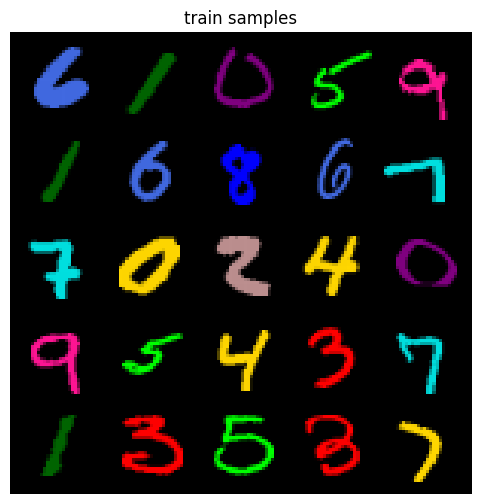

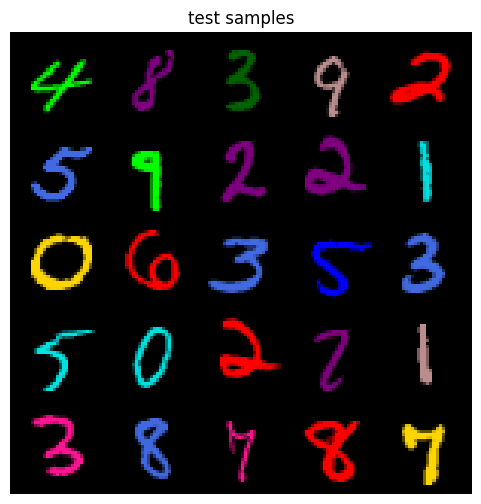

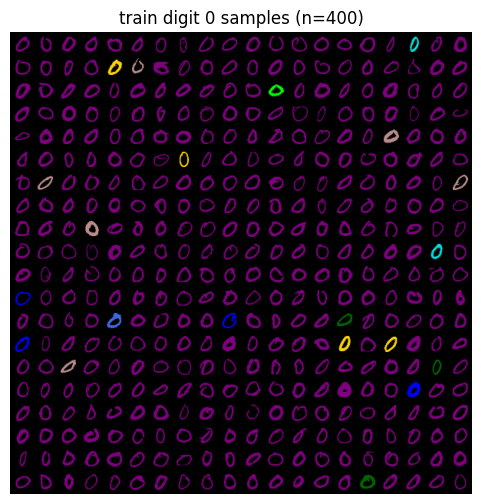

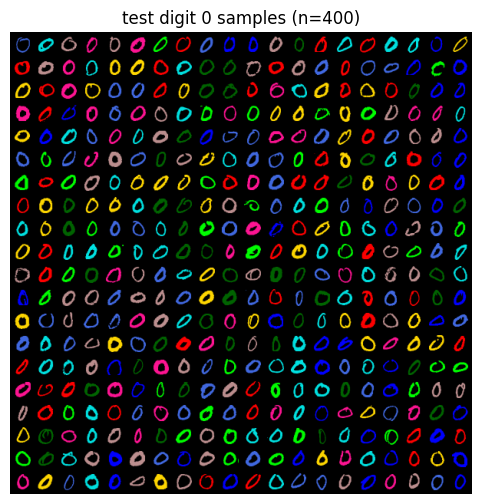

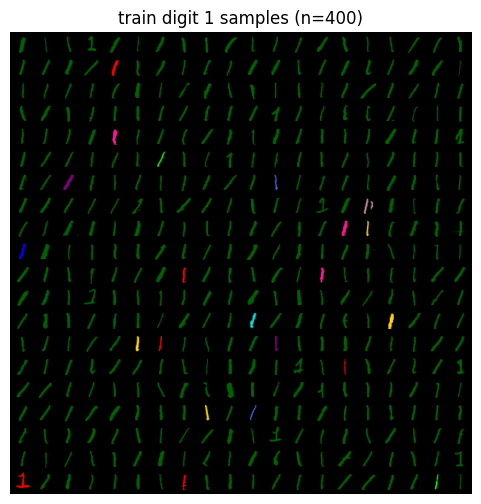

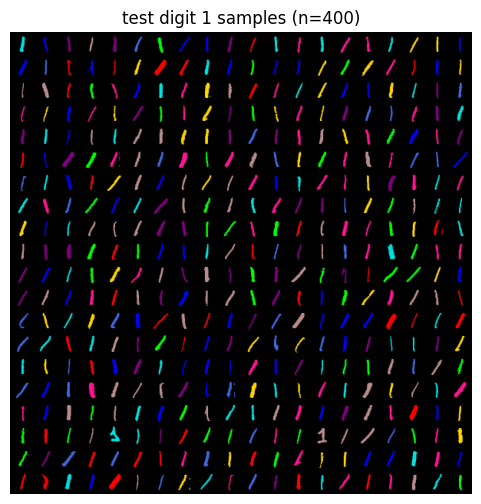

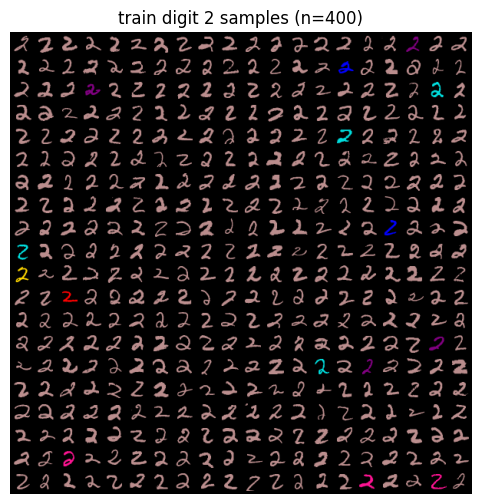

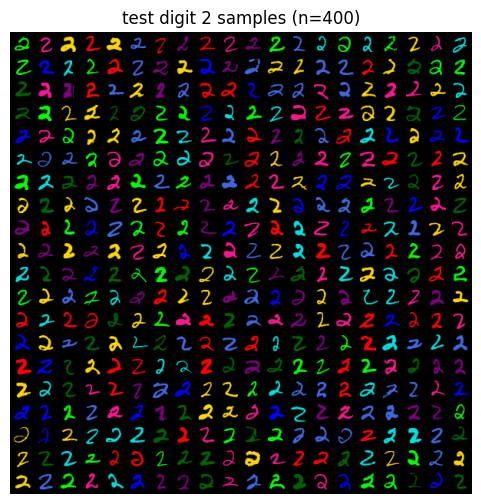

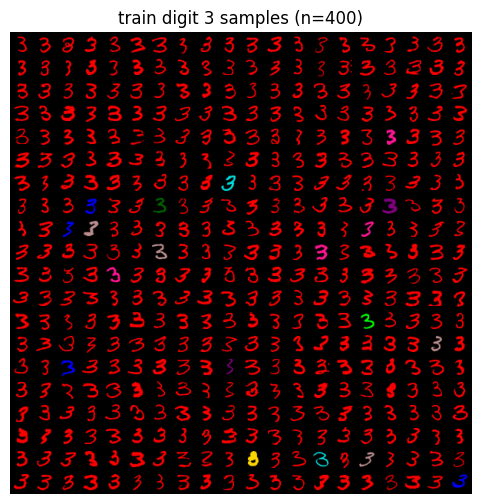

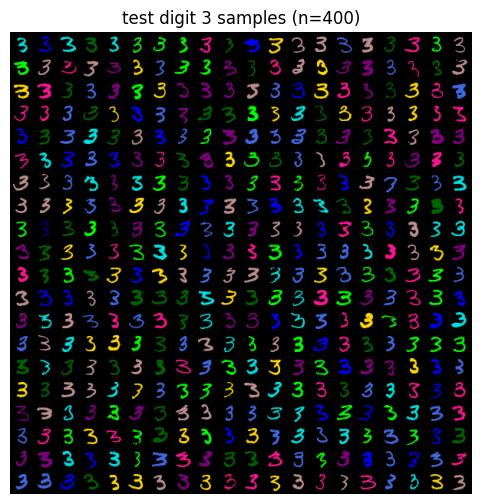

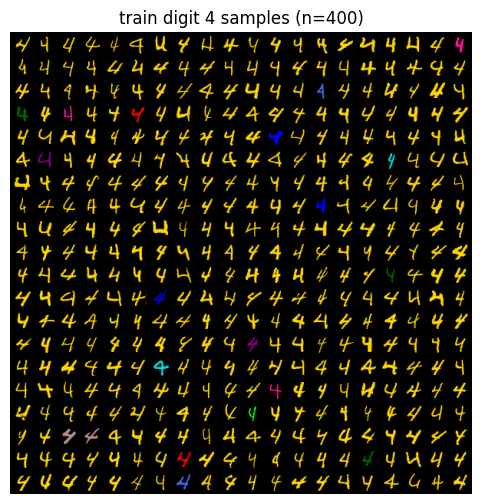

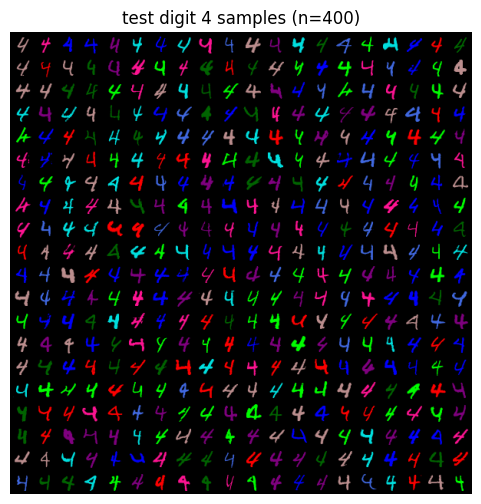

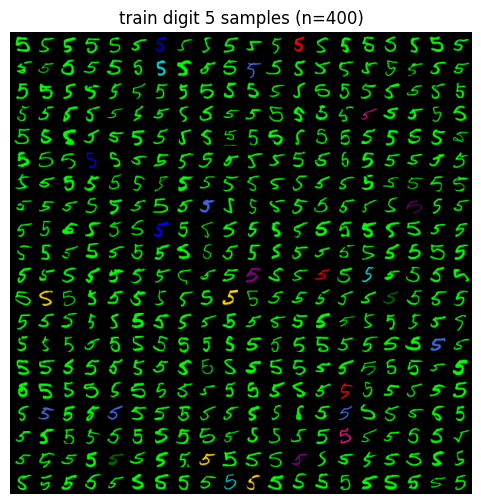

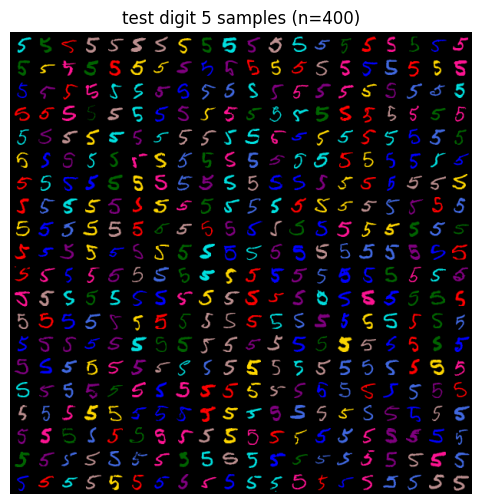

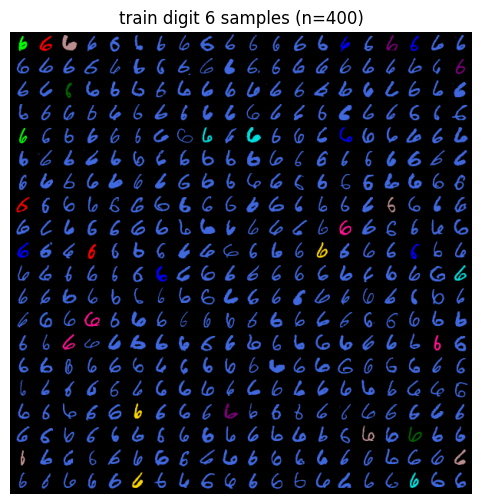

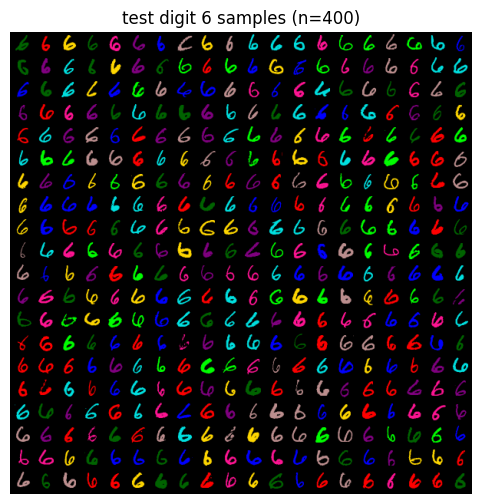

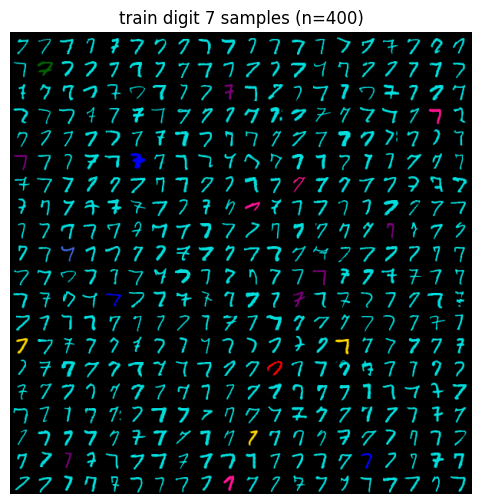

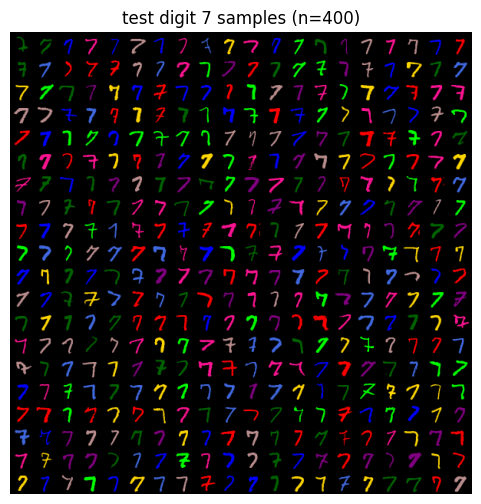

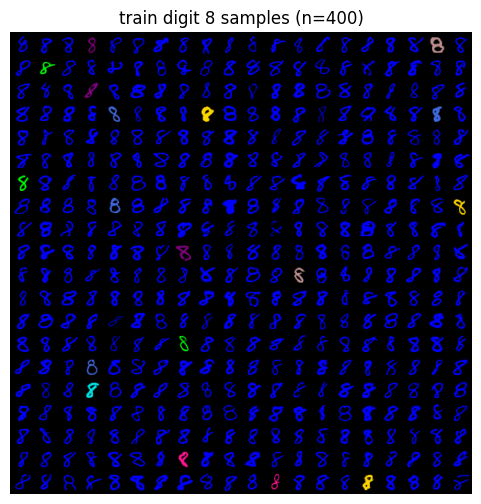

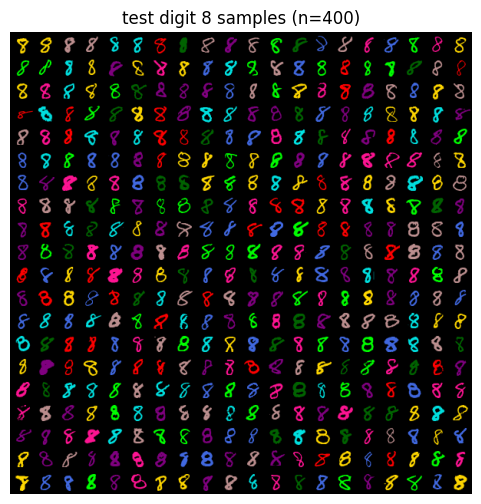

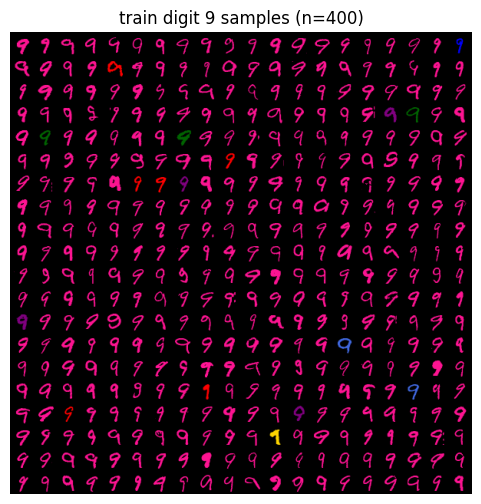

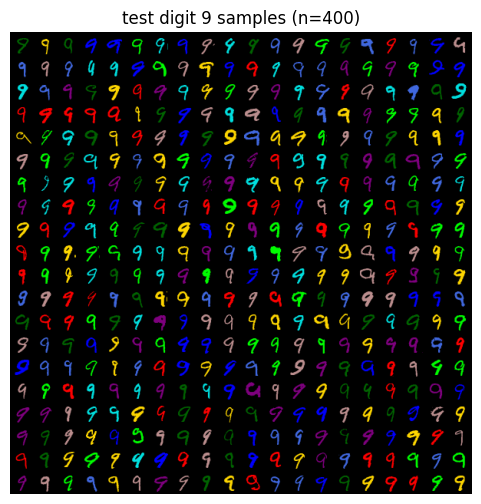

In [5]:
def _load_rgb(split: str, filename: str) -> torch.Tensor:
    path = DATA_ROOT / split / "images" / filename
    return BASE_TRANSFORM(Image.open(path).convert("RGB"))


def check_bias_ratio(meta: pd.DataFrame, split: str) -> None:
    match_rate = (meta.label == meta.color_digit).mean() # mean of a true flase list automatically gives fraction of true values
    print(f"[{split}] color==label: {match_rate * 100:.2f}% (target ~{BIASED_PROB * 100:.0f}% for train, 0% for test)")


def check_color_consistency(meta: pd.DataFrame, split: str, sample_size: int = 256) -> None:
    subset = meta.sample(min(sample_size, len(meta)), random_state=SEED) # random sample of rows from meta df
    max_std = 0.0
    for _, row in subset.iterrows():
        img = _load_rgb(split, row.filename)
        luminance = img.mean(dim=0) # collapse color channels to get per-pixel brightness : R+G+B/3 per pixel and (28,28) sizes is o/p
        digit_mask = luminance > 0.1  # classify digit pixels
        channel_std = img.std(dim=0) # calculates std dev of every pixel across the 3 color channels
        if digit_mask.any():
            max_std = max(max_std, channel_std[digit_mask].max().item()) # get the max std dev value across all 3 channels for pixels inside digit area
    print(f"[{split}] max channel std inside digit mask: {max_std:.4f} (expect near 0)")


def show_sample_grid(split: str, n: int = 25, title: Optional[str] = None) -> None:
    meta = load_meta(split)
    subset = meta.sample(min(n, len(meta)), random_state=SEED)
    imgs = [_load_rgb(split, row.filename) for _, row in subset.iterrows()]
    grid = make_grid(torch.stack(imgs), nrow=int(math.sqrt(len(imgs))), padding=2)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title(title or f"{split} samples")
    plt.show()


def plot_color_hist(meta: pd.DataFrame, split: str, sample_size: int = 2000) -> None:
    subset = meta.sample(min(sample_size, len(meta)), random_state=SEED)
    per_digit = {d: [] for d in range(10)}
    for _, row in subset.iterrows():
        img = _load_rgb(split, row.filename)
        per_digit[row.label].append(img.mean(dim=(1, 2)))
    means = {d: (torch.stack(vals).mean(0) if vals else torch.zeros(3)) for d, vals in per_digit.items()}
    channels = ["R", "G", "B"]
    fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
    for c_idx, channel in enumerate(channels):
        axes[c_idx].bar(range(10), [means[d][c_idx].item() for d in range(10)], color=channel.lower())
        axes[c_idx].set_ylabel(channel)
    axes[-1].set_xticks(range(10))
    axes[-1].set_xlabel("Digit label")
    fig.suptitle(f"Mean digit color per digit ({split})")
    plt.tight_layout()
    plt.show()


def show_digit_samples(digit: int, n_train: int = 16, n_test: int = 16, title: Optional[str] = None) -> None:
    """Display grids of a specific digit from both train and test splits.

    Args:
        digit (int): Target digit (0-9) to visualize.
        n_train (int): Number of train images to show.
        n_test (int): Number of test images to show.
        title (str, optional): Optional title prefix for the plots.

    Returns:
        None. Renders two matplotlib grids (train and test).
    """
    train_meta = load_meta("train")
    test_meta = load_meta("test")

    train_subset = train_meta[train_meta.label == digit]
    test_subset = test_meta[test_meta.label == digit]

    if train_subset.empty:
        print(f"No train samples of digit {digit} found.")
    else:
        take = min(n_train, len(train_subset))
        sampled = train_subset.sample(take, random_state=SEED)
        imgs = [_load_rgb("train", row.filename) for _, row in sampled.iterrows()]
        grid = make_grid(torch.stack(imgs), nrow=int(math.sqrt(len(imgs))), padding=2)
        plt.figure(figsize=(6, 6))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(title or f"train digit {digit} samples (n={take})")
        plt.show()

    if test_subset.empty:
        print(f"No test samples of digit {digit} found.")
    else:
        take = min(n_test, len(test_subset))
        sampled = test_subset.sample(take, random_state=SEED)
        imgs = [_load_rgb("test", row.filename) for _, row in sampled.iterrows()]
        grid = make_grid(torch.stack(imgs), nrow=int(math.sqrt(len(imgs))), padding=2)
        plt.figure(figsize=(6, 6))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(title or f"test digit {digit} samples (n={take})")
        plt.show()


def run_sanity_checks(run_grid: bool = True, run_hist: bool = True) -> None:
    try:
        train_meta = load_meta("train")
        test_meta = load_meta("test")
    except FileNotFoundError as err:
        print(err)
        return
    check_bias_ratio(train_meta, "train")
    check_bias_ratio(test_meta, "test")
    check_color_consistency(train_meta, "train")
    if run_grid:
        show_sample_grid("train", n=25)
        show_sample_grid("test", n=25)
    if run_hist:
        plot_color_hist(train_meta, "train")


print("Sanity check helpers ready. Call run_sanity_checks() after generating the splits.")
run_sanity_checks(True, False)
for i in range (0,10):
    show_digit_samples(i,400,400)
